In [1]:
pip install datasets tensorflow opencv-python matplotlib pandas scikit-learn

In [2]:
# STEP 0: Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==============================
# CONFIGURATION
# ==============================
IMG_SIZE = 128
DATA_PATH = "/content/drive/MyDrive/garbage_classification"
print("[INFO] Starting TrashNet data loading & preprocessing...")

[INFO] Starting TrashNet data loading & preprocessing...


In [4]:
# ==============================
# IMAGE ENHANCEMENT FUNCTION
# ==============================
def preprocess_image(img):
    # Resize to fixed size
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel for adaptive contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Convert BGR → RGB and normalize with MobileNetV2 preprocessing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img.astype("float32"))
    return img

In [5]:
# ==============================
# DATA LOADING
# ==============================
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


images, labels = [], []

for category in os.listdir(DATA_PATH):
    class_folder = os.path.join(DATA_PATH, category)
    if not os.path.isdir(class_folder):
        continue

    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_processed = preprocess_image(img)
            images.append(img_processed)
            labels.append(category)
        except Exception as e:
            print(f"[WARN] Could not process {img_path}: {e}")

# Convert lists to NumPy arrays
X = np.array(images, dtype="float32")
y = np.array(labels)

# Encode labels → one-hot
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)

print(f"[INFO] Dataset ready: {len(X_train)} train | {len(X_val)} validation")
print(f"[INFO] Classes: {label_encoder.classes_}")

[INFO] Dataset ready: 7594 train | 1899 validation
[INFO] Classes: ['battery' 'biological' 'brown-glass' 'cardboard' 'green-glass' 'metal'
 'paper' 'plastic' 'shoes' 'white-glass']


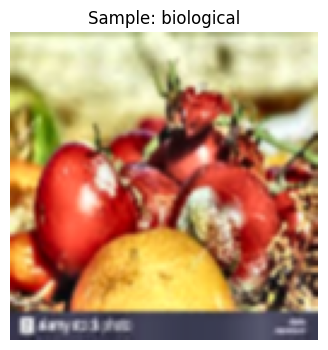

In [6]:
# ==============================
# VISUALIZE SAMPLE IMAGE
# ==============================
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.imshow((X_train[0] + 1) / 2)  # Convert back from [-1,1] to [0,1] for visualization
plt.title(f"Sample: {label_encoder.inverse_transform([np.argmax(y_train[0])])[0]}")
plt.axis("off")
plt.show()

In [7]:
# ==============================
# DATA AUGMENTATION
# ==============================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest"
)

val_gen = ImageDataGenerator()

train_data = train_gen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_data = val_gen.flow(X_val, y_val, batch_size=32, shuffle=False)

In [8]:
# ==============================
# MODEL ARCHITECTURE
# ==============================
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze feature extractor

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output_layer = Dense(len(label_encoder.classes_), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# ==============================
# TRAINING
# ==============================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(patience=3, factor=0.3, verbose=1, monitor="val_loss"),
    ModelCheckpoint("mobilenetv2_garbage_best.keras", save_best_only=True, monitor="val_accuracy")
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.4816 - loss: 1.7056 - val_accuracy: 0.8215 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.7731 - loss: 0.6922 - val_accuracy: 0.8489 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - accuracy: 0.7972 - loss: 0.6239 - val_accuracy: 0.8547 - val_loss: 0.4333 - learning_rate: 0.0010
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.8149 - loss: 0.5588 - val_accuracy: 0.8715 - val_loss: 0.3884 - learning_rate: 0.0010
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.8274 - loss: 0.5091 - val_accuracy: 0.8726 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.8329 - loss: 0.4965 - val_accuracy: 0.8631 - val_loss: 0.3970 - learning_rate: 0.0010
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.8

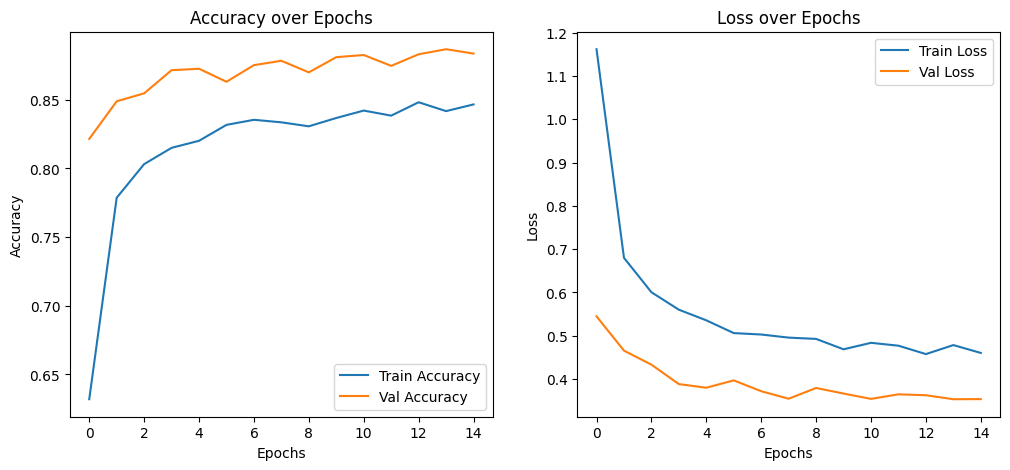

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       189
           1       0.95      0.97      0.96       197
           2       0.87      0.92      0.89       121
           3       0.93      0.84      0.88       178
           4       0.92      0.94      0.93       126
           5       0.75      0.81      0.78       154
           6       0.83      0.86      0.84       210
           7       0.81      0.76      0.78       173
           8       0.95      0.98      0.97       396
           9       0.85      0.71      0.77       155

    accuracy                           0.89      1899
   macro avg       0.88      0.87      0.87      1899
weighted avg       0.89      0.89      0.89      1899



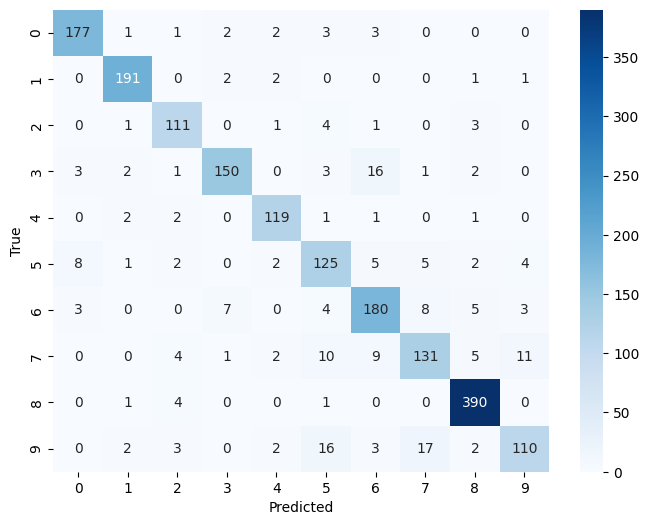

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred =model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

[RESULT] Test Accuracy: 0.8868, Test Loss: 0.3535


In [13]:
# Save model in modern Keras format
model.save("mobilenet_trash.keras")

# Load model
from tensorflow.keras.models import load_model
loaded_model = load_model("mobilenet_trash.keras")

# Recompile to ensure metrics are set
loaded_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [14]:
import pickle

# Save model with pickle
with open("mobilenet_trashn.pkl", "wb") as f:
    pickle.dump(model, f)

# Load model later
with open("mobilenet_trashn.pkl", "rb") as f:
    loaded_model = pickle.load(f)


Saving bio-waste-in-the-bin-2A3P6TG.jpg to bio-waste-in-the-bin-2A3P6TG.jpg
[RESULT] Predicted Class: biological
[CONFIDENCE] 96.02%


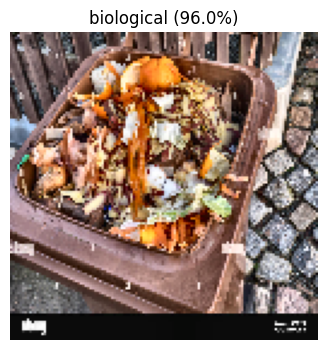

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # keep consistent with training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image from disk, applies custom preprocessing, and returns:
    - img_rgb: RGB image (for display)
    - img_input: preprocessed, batch-ready image (for model prediction)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # =========================
    # CUSTOM PREPROCESSING
    # =========================
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise


    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess for MobileNetV2
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)  # add batch dimension

    return img_rgb, img_input


def predict_and_display(model, img_path, label_encoder):
    """
    Uses preprocess_single_image_for_display, predicts class,
    and shows the image with predicted label + confidence.
    """
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100

    # Print result
    print(f"[RESULT] Predicted Class: {predicted_class}")
    print(f"[CONFIDENCE] {confidence:.2f}%")

    # Display image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()


# ==============================
# USAGE EXAMPLE
# ==============================
# Example for Colab
from google.colab import files
uploaded = files.upload()

for img_file in uploaded.keys():
    predict_and_display(model, img_file, label_encoder)


Saving th.jpeg to th (1).jpeg
[RESULT] Predicted Class: cardboard
[CONFIDENCE] 99.99%


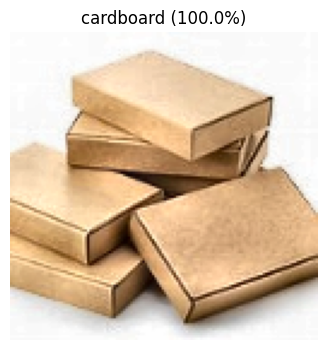

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # keep consistent with training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image from disk, applies custom preprocessing, and returns:
    - img_rgb: RGB image (for display)
    - img_input: preprocessed, batch-ready image (for model prediction)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # =========================
    # CUSTOM PREPROCESSING
    # =========================
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise


    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess for MobileNetV2
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)  # add batch dimension

    return img_rgb, img_input


def predict_and_display(model, img_path, label_encoder):
    """
    Uses preprocess_single_image_for_display, predicts class,
    and shows the image with predicted label + confidence.
    """
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100

    # Print result
    print(f"[RESULT] Predicted Class: {predicted_class}")
    print(f"[CONFIDENCE] {confidence:.2f}%")

    # Display image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()


# ==============================
# USAGE EXAMPLE
# ==============================
# Example for Colab
from google.colab import files
uploaded = files.upload()

for img_file in uploaded.keys():
    predict_and_display(model, img_file, label_encoder)


Saving plastic.jpeg to plastic.jpeg
[RESULT] Predicted Class: plastic
[CONFIDENCE] 99.97%


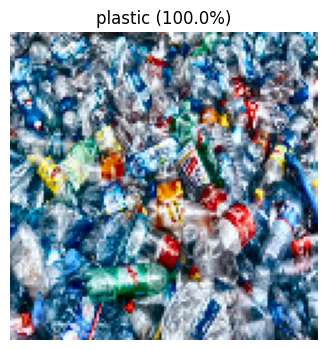

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # keep consistent with training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image from disk, applies custom preprocessing, and returns:
    - img_rgb: RGB image (for display)
    - img_input: preprocessed, batch-ready image (for model prediction)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # =========================
    # CUSTOM PREPROCESSING
    # =========================
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise


    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess for MobileNetV2
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)  # add batch dimension

    return img_rgb, img_input


def predict_and_display(model, img_path, label_encoder):
    """
    Uses preprocess_single_image_for_display, predicts class,
    and shows the image with predicted label + confidence.
    """
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100

    # Print result
    print(f"[RESULT] Predicted Class: {predicted_class}")
    print(f"[CONFIDENCE] {confidence:.2f}%")

    # Display image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()


# ==============================
# USAGE EXAMPLE
# ==============================
# Example for Colab
from google.colab import files
uploaded = files.upload()

for img_file in uploaded.keys():
    predict_and_display(model, img_file, label_encoder)


Saving shoe.jpg to shoe.jpg
[RESULT] Predicted Class: shoes
[CONFIDENCE] 99.85%


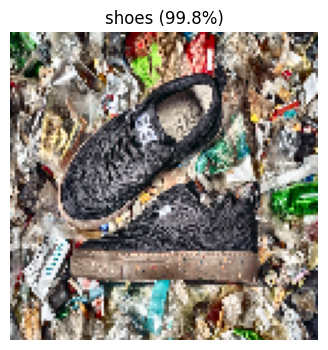

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # keep consistent with training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image from disk, applies custom preprocessing, and returns:
    - img_rgb: RGB image (for display)
    - img_input: preprocessed, batch-ready image (for model prediction)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # =========================
    # CUSTOM PREPROCESSING
    # =========================
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise


    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess for MobileNetV2
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)  # add batch dimension

    return img_rgb, img_input


def predict_and_display(model, img_path, label_encoder):
    """
    Uses preprocess_single_image_for_display, predicts class,
    and shows the image with predicted label + confidence.
    """
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100

    # Print result
    print(f"[RESULT] Predicted Class: {predicted_class}")
    print(f"[CONFIDENCE] {confidence:.2f}%")

    # Display image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()


# ==============================
# USAGE EXAMPLE
# ==============================
# Example for Colab
from google.colab import files
uploaded = files.upload()

for img_file in uploaded.keys():
    predict_and_display(model, img_file, label_encoder)


Saving metal.webp to metal.webp
[RESULT] Predicted Class: metal
[CONFIDENCE] 74.42%


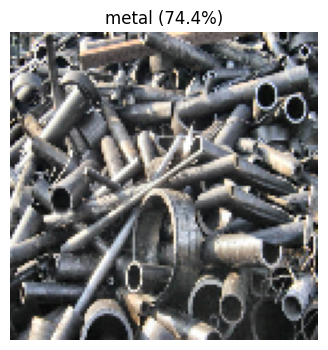

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # keep consistent with training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image from disk, applies custom preprocessing, and returns:
    - img_rgb: RGB image (for display)
    - img_input: preprocessed, batch-ready image (for model prediction)
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # =========================
    # CUSTOM PREPROCESSING
    # =========================
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE on L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Slight Gaussian blur to reduce noise


    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess for MobileNetV2
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)  # add batch dimension

    return img_rgb, img_input


def predict_and_display(model, img_path, label_encoder):
    """
    Uses preprocess_single_image_for_display, predicts class,
    and shows the image with predicted label + confidence.
    """
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    confidence = prediction[0][predicted_class_idx] * 100

    # Print result
    print(f"[RESULT] Predicted Class: {predicted_class}")
    print(f"[CONFIDENCE] {confidence:.2f}%")

    # Display image with title
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.1f}%)")
    plt.axis("off")
    plt.show()


# ==============================
# USAGE EXAMPLE
# ==============================
# Example for Colab
from google.colab import files
uploaded = files.upload()

for img_file in uploaded.keys():
    predict_and_display(model, img_file, label_encoder)
